In [1]:
import time
import torch
import pickle
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import TAGConv, GATConv
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.loader import DataLoader as pyg_DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
with open('Training_dataset_LA_small.p', 'rb') as handle:
    tra_dataset_pyg = pickle.load(handle)
with open('Validation_dataset_LA_small.p', 'rb') as handle:
    val_dataset_pyg = pickle.load(handle)
with open('Test_dataset_LA_small.p', 'rb') as handle:
    tst_dataset_pyg = pickle.load(handle)

In [4]:
print('Number of training examples:',   len(tra_dataset_pyg))
print('Number of validation examples:', len(val_dataset_pyg))
print('Number of test examples:',       len(tst_dataset_pyg))

Number of training examples: 8000
Number of validation examples: 1000
Number of test examples: 1000


In [5]:
tra_dataset_pyg[0]

Data(x=[50, 12], edge_index=[2, 300], edge_attr=[300, 1], y=[50, 12])

In [27]:
class My_GNN(nn.Module):
    """
    This class defines a PyTorch module that takes in a graph represented in the PyTorch Geometric Data format,
    and outputs a tensor of predictions for each node in the graph. The model consists of one or more GATConv layers,
    which are a type of graph convolutional layer.

    Args:
        node_dim (int): The number of node inputs.
        edge_dim (int): The number of edge inputs.
        output_dim (int, optional): The number of outputs (default: 1).
        hidden_dim (int, optional): The number of hidden units in each GNN layer (default: 50).
        n_gnn_layers (int, optional): The number of GNN layers in the model (default: 1).
        K (int, optional): The number of hops in the neighbourhood for each GNN layer (default: 2).
        dropout_rate (float, optional): The dropout rate to be applied to the output of each GNN layer (default: 0).

    """
    def __init__(self, node_dim, edge_dim, output_dim=1, hidden_dim=50, n_gnn_layers=1, K=2, dropout_rate=0):
        super().__init__()
        self.node_dim = node_dim          
        self.edge_dim = edge_dim          
        self.output_dim = output_dim      
        self.hidden_dim = hidden_dim      
        self.n_gnn_layers = n_gnn_layers  
        self.K = K                        
        self.dropout_rate = dropout_rate

        self.convs = nn.ModuleList()
        self.prelus = nn.ModuleList()

        if n_gnn_layers == 1:
            self.convs.append(GATConv(node_dim, output_dim, heads=K, dropout=dropout_rate))
        else:
            self.convs.append(GATConv(node_dim, hidden_dim, heads=K, dropout=dropout_rate))
            self.prelus.append(nn.PReLU())

            for l in range(n_gnn_layers-2):
                self.convs.append(GATConv(hidden_dim, hidden_dim, heads=K, dropout=dropout_rate))
                self.prelus.append(nn.PReLU())

            self.convs.append(GATConv(hidden_dim, output_dim, heads=K, dropout=dropout_rate))

    def forward(self, data):
        """Applies the GNN to the input graph.

          Args:
              data (Data): A PyTorch Geometric Data object representing the input graph.

          Returns:
              torch.Tensor: The output tensor of the GNN.

          """
        x = data.x.float()
#         print(edge_index.shape)
        edge_index = data.edge_index.long()
#         print(edge_index)
        edge_attr = data.edge_attr.float()

      # print(x.shape)
      
        for i in range(len(self.convs)-1):
            x = self.convs[i](x=x, edge_index=edge_index, edge_attr=edge_attr)
            # print(x.shape)
            x = nn.Dropout(self.dropout_rate, inplace=False)(x)
            x = self.prelus[i](x)
      
        x = self.convs[-1](x=x, edge_index=edge_index, edge_attr=edge_attr)
      # x = nn.Sigmoid()(x)
      
        return x

In [28]:
# Set model parameters
node_dim =   tra_dataset_pyg[0].x.shape[1]
edge_dim =   tra_dataset_pyg[0].edge_attr.shape[1]
output_dim = tra_dataset_pyg[0].y.shape[1]
hidden_dim = 16
n_gnn_layers = 3
K=1
dropout_rate = 0.1

# Create model
model = My_GNN(node_dim, edge_dim, output_dim, hidden_dim, n_gnn_layers, K, dropout_rate).to(device)
print(model)

My_GNN(
  (convs): ModuleList(
    (0): GATConv(12, 16, heads=1)
    (1): GATConv(16, 16, heads=1)
    (2): GATConv(16, 12, heads=1)
  )
  (prelus): ModuleList(
    (0-1): 2 x PReLU(num_parameters=1)
  )
)


#### Training epoch function

In [34]:
def train_epoch(model, loader, optimizer, device='cpu'):
  """
    Trains a neural network model for one epoch using the specified data loader and optimizer.

    Args:
        model (nn.Module): The neural network model to be trained.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): The PyTorch optimizer used for training the model.
        device (str): The device used for training the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """
  
  # opt = torch.optim.Adam(model.parameters(), lr=0.001)
  losses = []
  for batch in loader:
    batch = batch.to(device) # GPU

    optimizer.zero_grad()
    y_hat = model(batch)
    loss = nn.MSELoss()
    loss = loss(batch.y, y_hat)
    loss.backward()
    optimizer.step()
    losses.append(loss.cpu().detach().numpy())

  return np.mean(losses)

#### Testing epoch function

In [35]:
def evaluate_epoch(model, loader, device='cpu'):
    """
    Evaluates the performance of a trained neural network model on a dataset using the specified data loader.

    Args:
        model (nn.Module): The trained neural network model to be evaluated.
        loader (DataLoader): The PyTorch Geometric DataLoader containing the evaluation data.
        device (str): The device used for evaluating the model (default: 'cpu').

    Returns:
        float: The mean loss value over all the batches in the DataLoader.

    """

    losses = []
    for batch in loader:
      batch = batch.to(device) # GPU

      y_hat = model(batch)
      loss = nn.MSELoss()
      loss = loss(batch.y, y_hat)
      losses.append(loss.cpu().detach().numpy())

    return np.mean(losses)

#### Optimization of the Model

In [36]:
# Set training parameters
learning_rate = 0.001
batch_size = 16
num_epochs = 100

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the GNN in batches
tra_loader = pyg_DataLoader(tra_dataset_pyg, batch_size=batch_size, shuffle=True)
val_loader = pyg_DataLoader(val_dataset_pyg, batch_size=batch_size, shuffle=False)

In [37]:
for b in tra_loader:
    print(b.x.shape)
    print(b.edge_index.shape)
    print(b.edge_attr.shape)
    ei = b.x
    break
    
ei

torch.Size([800, 12])
torch.Size([2, 4800])
torch.Size([4800, 1])


tensor([[65.1250, 66.6667, 66.7500,  ..., 64.3750, 64.1111, 65.3750],
        [68.2500, 67.6667, 69.2500,  ..., 69.3750, 67.2222, 68.0000],
        [63.3750, 65.4444, 65.5000,  ..., 60.0000, 65.6667, 60.2500],
        ...,
        [65.7778, 65.1111, 64.4286,  ..., 64.0000, 61.2500, 64.2222],
        [68.1111, 67.3333, 66.4286,  ..., 68.4444, 69.1250, 68.8889],
        [65.4444, 65.1111, 65.5714,  ..., 64.8889, 66.2500, 58.0000]])

In [38]:
#create vectors for the training and validation loss
train_losses = []
val_losses = []
patience = 5       # patience for early stopping

#start measuring time
start_time = time.time()

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, tra_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluate_epoch(model, val_loader, device=device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early stopping
    try:
        if val_losses[-1]>=val_losses[-2]:
            early_stop += 1
            if early_stop == patience:
                print("Early stopping! Epoch:", epoch)
                break
        else:
            early_stop = 0
    except:
        early_stop = 0

    print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                        "\t validation loss:", np.round(val_loss,4))

elapsed_time = time.time() - start_time
print(f'Model training took {elapsed_time:.3f} seconds')

epoch: 1 	 training loss: 656.1928 	 validation loss: 355.0832
epoch: 2 	 training loss: 364.7518 	 validation loss: 344.9032
epoch: 3 	 training loss: 355.1952 	 validation loss: 328.0034
epoch: 4 	 training loss: 348.3899 	 validation loss: 329.8742
epoch: 5 	 training loss: 341.3016 	 validation loss: 328.2246
epoch: 6 	 training loss: 335.848 	 validation loss: 332.0904
epoch: 7 	 training loss: 326.6578 	 validation loss: 308.9557
epoch: 8 	 training loss: 322.4892 	 validation loss: 307.2739
epoch: 9 	 training loss: 320.3303 	 validation loss: 303.4664
epoch: 10 	 training loss: 319.2312 	 validation loss: 303.2409
epoch: 11 	 training loss: 313.6359 	 validation loss: 299.9119
epoch: 12 	 training loss: 314.0602 	 validation loss: 299.3229
epoch: 13 	 training loss: 310.9193 	 validation loss: 299.253
epoch: 14 	 training loss: 309.2893 	 validation loss: 289.5578
epoch: 15 	 training loss: 307.0477 	 validation loss: 289.6408
epoch: 16 	 training loss: 305.8572 	 validation lo

KeyboardInterrupt: 

In the following cell, plot the loss as function of epochs

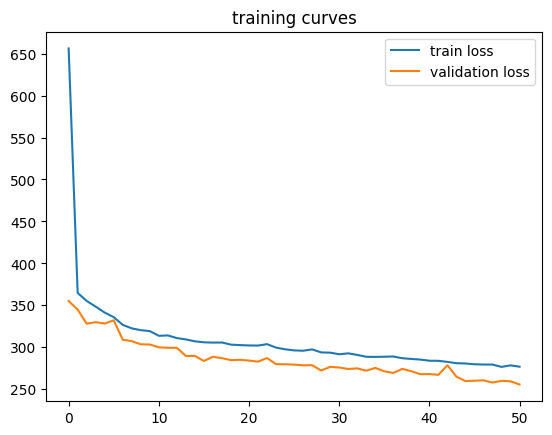

In [39]:
# plot the training and validation loss curves
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.title('training curves')
plt.legend()

In [54]:
tst_dataset_pyg

ys = []
for data in tst_dataset_pyg:
    ys.append(model(data.to(device)).cpu().detach().numpy())

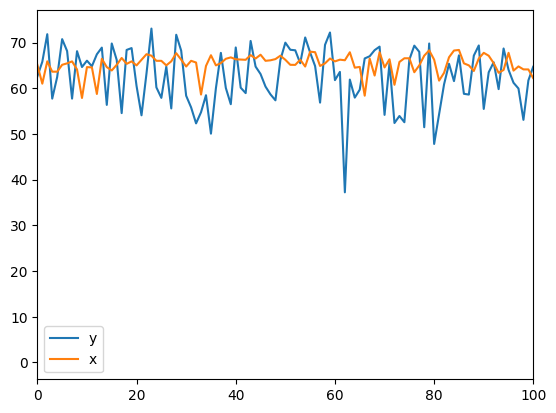

In [71]:
ys_r = np.array([y[0] for y in ys])
xs = np.array([data.x[0].cpu().detach().numpy() for data in tst_dataset_pyg])

plt.plot(ys_r[:-12, 0], label='y')
plt.plot(xs[12:, 0], label='x')
plt.xlim(0, 100)
plt.legend()
plt.show()